## Statistics and Modeling
In this Notebook, I am going to perform Hypothesis Testing and Build a Churn Prediction Model.

In [1]:
# importing required libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the csv file
df = pd.read_csv('/kaggle/input/e-commerce-cleaned-data/cleaned_data.csv')

# Preview the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Hypothesis Testing

 Testing if the average purchase value is different across countries.

In [3]:
# Creating a new column of Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Group data by country and calculate average purchase value
country_avg_purchase = df.groupby('Country')['TotalPrice'].mean()
country_avg_purchase.sort_values(ascending=False).head()

Country
Netherlands    116.846387
Australia      116.571074
Japan           93.951003
Sweden          85.261844
Denmark         49.905251
Name: TotalPrice, dtype: float64

Performing ANOVA-
- H₀: All countries have the same average purchase value
- H₁: At least one country has a different average

In [4]:
from scipy.stats import f_oneway

# Create a list of total purchases by country
grouped_data = [df[df['Country'] == country]['TotalPrice'] for country in df['Country'].unique()]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*grouped_data)
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")


F-statistic: 141.37, p-value: 0.0000


### Interpretation:
p-value < 0.05 → Reject the null hypothesis.  
It means there is a statistically significant difference in average purchase value across countries.

## Churn Prediction Model
Predicting which customers are likely to churn.

We'll define churned customers as those who have not purchased in the last 3 months.

In [5]:
# Defining the Churn Flag
import datetime as dt

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

latest_date = df['InvoiceDate'].max()
cutoff_date = latest_date - pd.Timedelta(days=90)

# Last purchase date per customer
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()

# Label churn
churn_data = pd.DataFrame({'LastPurchaseDate': last_purchase})
churn_data['Churn'] = churn_data['LastPurchaseDate'] < cutoff_date
churn_data['Churn'] = churn_data['Churn'].astype(int)

In [6]:
# Feature Engineering RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalPrice': 'sum'                                     # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Merge with churn label
rfm = rfm.merge(churn_data[['Churn']], left_index=True, right_index=True)


In [7]:
# Building Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Features & Target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Option 1: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))

# Option 2: Decision Tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree Results:")
print(classification_report(y_test, y_pred_tree))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       1.00      1.00      1.00       270

    accuracy                           1.00       867
   macro avg       1.00      1.00      1.00       867
weighted avg       1.00      1.00      1.00       867

Decision Tree Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       1.00      1.00      1.00       270

    accuracy                           1.00       867
   macro avg       1.00      1.00      1.00       867
weighted avg       1.00      1.00      1.00       867



### Visualizing the Final Result

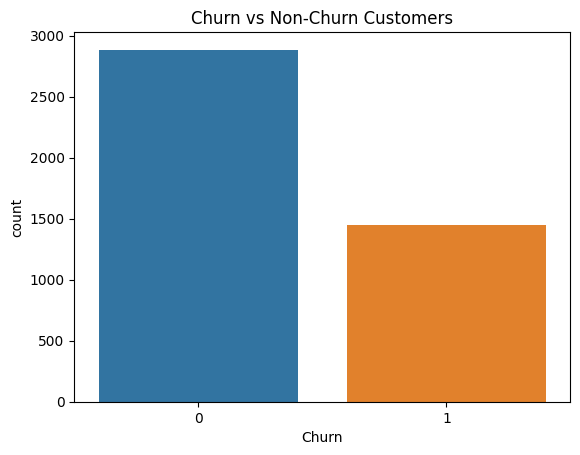

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot class distribution
sns.countplot(x='Churn', data=rfm)
plt.title("Churn vs Non-Churn Customers")
plt.show()
